# RandomForest para clasificación  

Importe de librerías necesarias

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

from sklearn.model_selection import GridSearchCV

Cargamos los datos y los dividimos en train y test.

In [40]:
data = pd.read_csv('data_cleaner.csv')

X = data.drop(columns=['AdoptionLikelihood'])
y = data['AdoptionLikelihood'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Primera parte

Definimos la función para experimentar con Random Forest

In [41]:
def experimentar_rf_clasificacion(X, y, num_trees, max_features_list, min_samples_leaf_list):
    resultados = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for n_estimators in num_trees:
        for max_features in max_features_list:
            for min_leaf in min_samples_leaf_list:
                auc_scores = []

                for train_idx, val_idx in skf.split(X, y):
                    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_features=max_features,
                        min_samples_leaf=min_leaf,
                        random_state=42,
                        n_jobs=-1
                    )
                    model.fit(X_tr, y_tr)
                    y_proba = model.predict_proba(X_val)[:, 1]
                    auc = roc_auc_score(y_val, y_proba)
                    auc_scores.append(auc)

                resultados.append({
                    'n_estimators': n_estimators,
                    'max_features': max_features,
                    'min_samples_leaf': min_leaf,
                    'mean_roc_auc': np.mean(auc_scores),
                    'std_roc_auc': np.std(auc_scores)
                })

        print(f"Finalizado para {n_estimators} árboles")

    return pd.DataFrame(resultados)

Definimos la malla de hiperparámetros que usaremos para escoger los mejores en cross-validation

In [42]:
arboles = [10, 50, 100, 150]
variables = [1, 2, 3, 5]
min_samples = [1, 5, 10, 15, 20]

Experimentamos con los datos anteriores

In [43]:
resultados_rf = experimentar_rf_clasificacion(X_train, y_train, arboles, variables, min_samples)

Finalizado para 10 árboles
Finalizado para 50 árboles
Finalizado para 100 árboles
Finalizado para 150 árboles


Imprimimos los mejores resultados ordenados

In [44]:
resultados_ordenados = resultados_rf.sort_values(by='mean_roc_auc', ascending=False)
print("Mejores combinaciones:")
print(resultados_ordenados.head(10))

Mejores combinaciones:
    n_estimators  max_features  min_samples_leaf  mean_roc_auc  std_roc_auc
55           100             5                 1      0.932976     0.018730
75           150             5                 1      0.932416     0.019337
46           100             2                 5      0.932138     0.015400
56           100             5                 5      0.931971     0.018861
76           150             5                 5      0.931706     0.018905
35            50             5                 1      0.931437     0.018145
70           150             3                 1      0.931334     0.016513
66           150             2                 5      0.931168     0.015718
37            50             5                10      0.931143     0.018020
36            50             5                 5      0.931059     0.017633


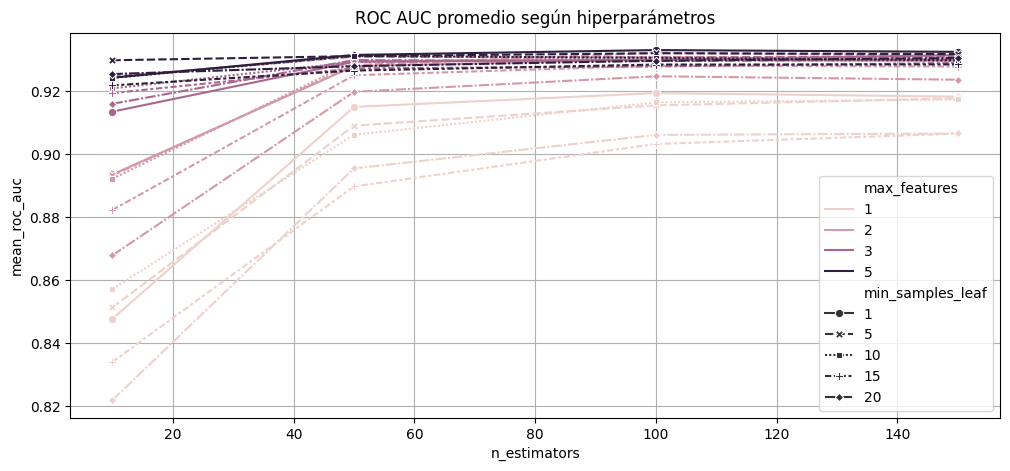

In [45]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=resultados_rf, x='n_estimators', y='mean_roc_auc', hue='max_features', style='min_samples_leaf', markers=True)
plt.title('ROC AUC promedio según hiperparámetros')
plt.grid()
plt.show()


In [46]:
mejores = resultados_ordenados.iloc[0]
modelo = RandomForestClassifier(
    n_estimators=int(mejores['n_estimators']),
    max_features=int(mejores['max_features']),
    min_samples_leaf=int(mejores['min_samples_leaf']),
    random_state=42,
    n_jobs=-1
)

In [47]:
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]

In [48]:
print("\n=== Métricas en el conjunto de prueba ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precisión: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")


=== Métricas en el conjunto de prueba ===
Accuracy:  0.908
Precisión: 0.886
Recall:    0.826
ROC AUC:   0.899


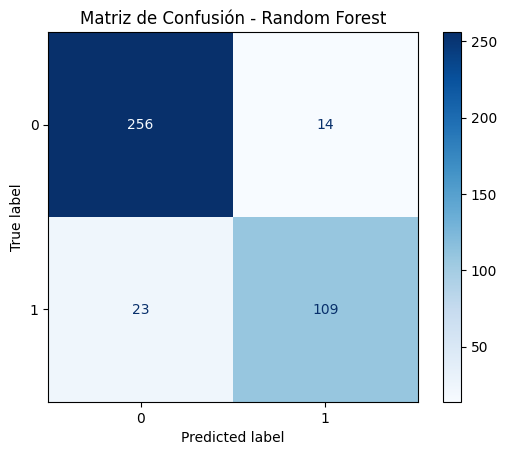

In [49]:
ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

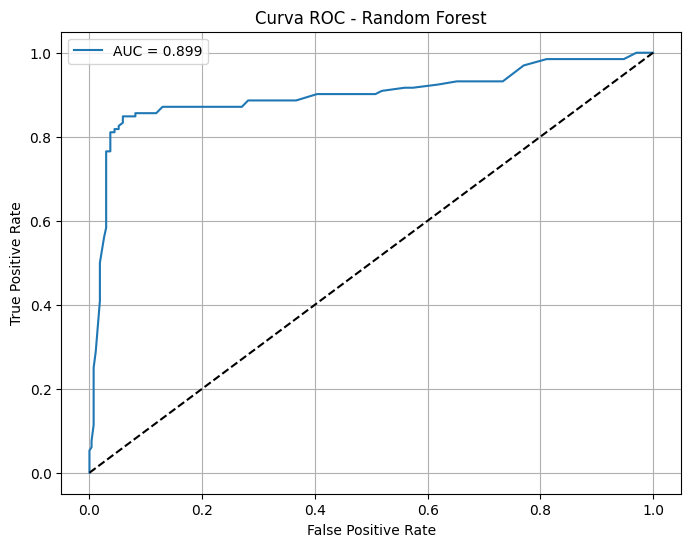

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.grid()
plt.show()

## Segunda parte
Búsqueda con Sklearn de los mejores parámetros, entrenamiento y validación de un RF classifier

In [52]:
rf = RandomForestClassifier(random_state=42)

Definimos la malla de hiperparámetros a evaluar

In [53]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
}

Definimos el objeto de stratified cross-validation. Es estratificada porque tenemos desbalance en la variable a predecir.  

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Definimos el objeto de grid search con la malla de hiperparámetros

In [55]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring={'precision': 'precision', 'recall': 'recall', 'roc_auc': 'roc_auc'},
    refit='roc_auc',
    n_jobs=-1,
    verbose=1
)

Empezamos la búsqueda de los mejores hiperparámetros para el modelo

In [56]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 150, 200]},
             refit='roc_auc',
             scoring={'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [57]:
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación ROC AUC:", grid_search.best_score_)

Mejores hiperparámetros encontrados: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación ROC AUC: 0.934793041751503


Entrenamos el modelo con los mejores hiperparámetros encontrados

In [58]:
rf = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=15, max_features='sqrt', min_samples_leaf=5, min_samples_split=15, n_estimators=100)

In [59]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=15)

Encontramos las métricas del modelo final

In [60]:
y_test_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

In [61]:
print("\n=== Métricas en el conjunto de prueba ===")
print(f"Precisión: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")


=== Métricas en el conjunto de prueba ===
Precisión: 0.913
Recall:    0.795
ROC AUC:   0.909


Graficamos la curva ROC

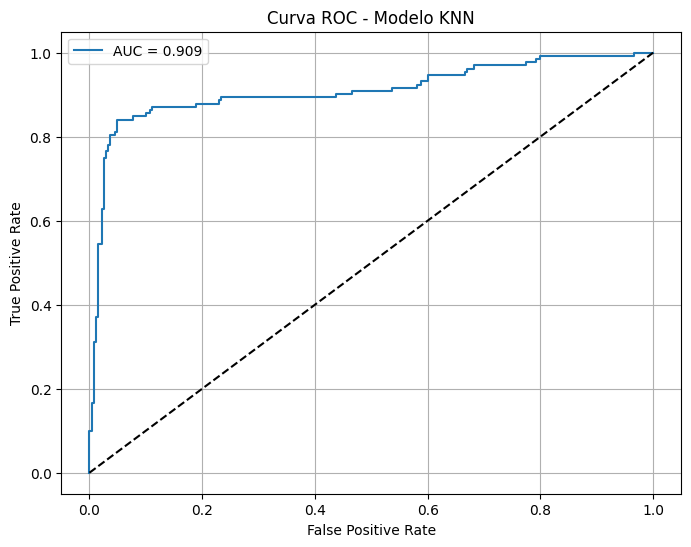

In [62]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo KNN')
plt.legend()
plt.grid()
plt.show()

## Tercera parte
Visualización de los efectos de los hiperparámetros sobre el modelo

In [63]:
resultados = pd.DataFrame(grid_search.cv_results_)

resultados['param_max_features'] = resultados['param_max_features'].astype(str)
resultados['param_criterion'] = resultados['param_criterion'].astype(str)
resultados['param_max_depth'] = resultados['param_max_depth'].astype(str)  # Opcional si quieres graficar esa también


Efecto del número de árboles

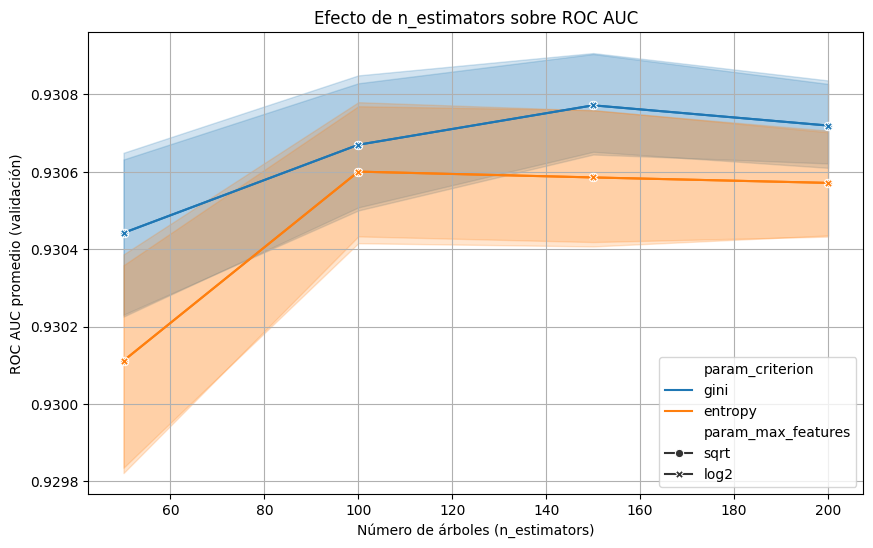

In [64]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=resultados,
    x='param_n_estimators',
    y='mean_test_roc_auc',
    hue='param_criterion',
    style='param_max_features',
    markers=True,
    dashes=False
)
plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('ROC AUC promedio (validación)')
plt.title('Efecto de n_estimators sobre ROC AUC')
plt.grid(True)
plt.show()


Efecto de la profundidad del árbol

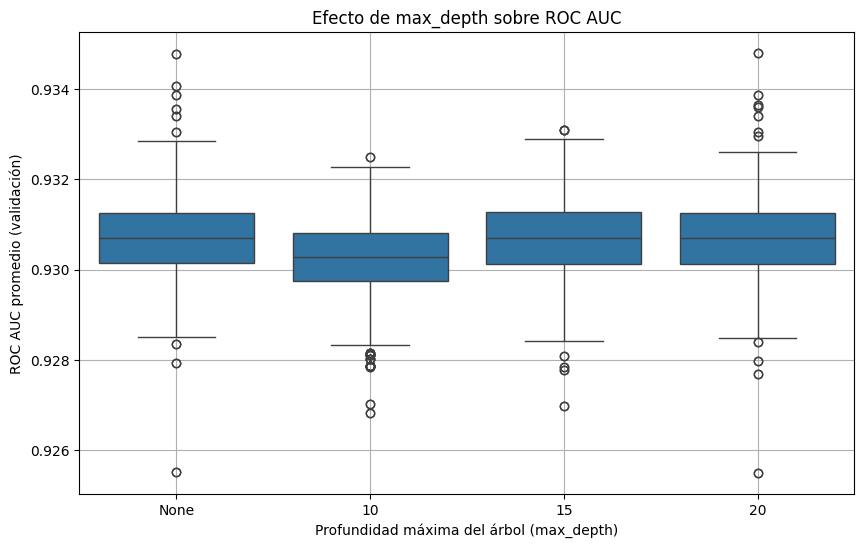

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='param_max_depth',
    y='mean_test_roc_auc',
    data=resultados
)
plt.xlabel('Profundidad máxima del árbol (max_depth)')
plt.ylabel('ROC AUC promedio (validación)')
plt.title('Efecto de max_depth sobre ROC AUC')
plt.grid(True)
plt.show()


Efecto del mínimo de muestras por hoja

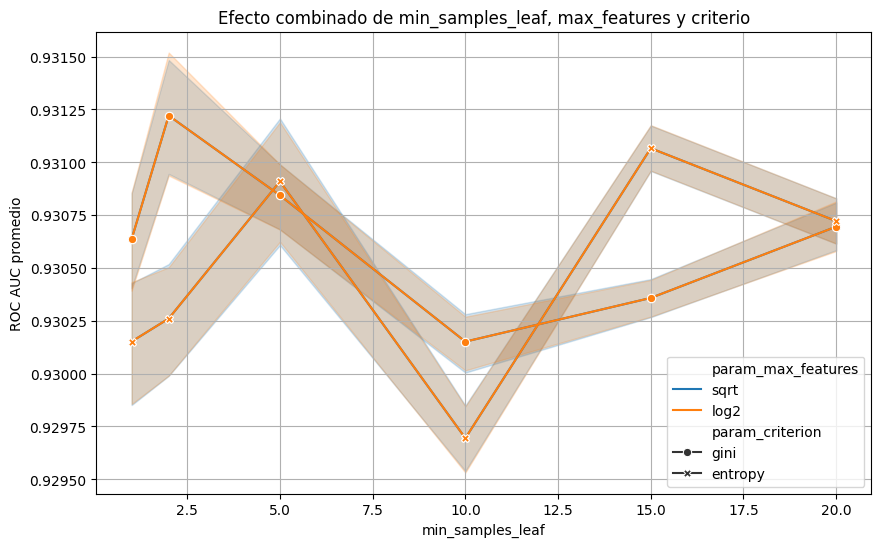

In [66]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=resultados,
    x='param_min_samples_leaf',
    y='mean_test_roc_auc',
    hue='param_max_features',
    style='param_criterion',
    markers=True,
    dashes=False
)
plt.xlabel('min_samples_leaf')
plt.ylabel('ROC AUC promedio')
plt.title('Efecto combinado de min_samples_leaf, max_features y criterio')
plt.grid(True)
plt.show()


In [67]:
mejor_idx = grid_search.best_index_
mejor_resultados = resultados.iloc[mejor_idx]

print("\n=== Resultados promedio del mejor modelo (Cross-Validation) ===")
print(f"- ROC AUC (validación): {mejor_resultados['mean_test_roc_auc']:.3f} ± {mejor_resultados['std_test_roc_auc']:.3f}")

# Si usaste return_train_score=True, también puedes mostrar métricas de entrenamiento:
if 'mean_train_score' in resultados.columns:
    print(f"- ROC AUC (entrenamiento): {mejor_resultados['mean_train_score']:.3f} ± {mejor_resultados['std_train_score']:.3f}")


=== Resultados promedio del mejor modelo (Cross-Validation) ===
- ROC AUC (validación): 0.935 ± 0.017
